### THE NLP MODEL FOR INPUT CLASSIFIER TO BENING, SUSPICIOUS, CRITICAL
This model will take input as santence or news articles or headlines and then outputs that whether the news is critical, benign or suspicious.

In [1]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt
import pickle


In [2]:
df = pd.read_csv("classification_dataset.csv")
df

,text,label
0,Sarah Miller warned of an impending attack in ...,critical
1,Sarah Miller confirmed a suspicious package wa...,suspicious
2,Military sources say Michelle Green planned a ...,critical
3,Michelle Green led a successful operation neut...,benign
4,John Carter led a successful operation neutral...,benign
...,...,...
61636,a couple was seen playing a flute around the s...,benign
61637,a student was spotted giving directions while ...,benign
61638,a man was spotted walking a dog while passing ...,benign
61639,a young woman was spotted hiding the face with...,suspicious


In [3]:
df['label'] = df['label'].str.lower().str.strip()
df['label'] = df['label'].map({'suspicious':0,'benign':-1,'critical':1})
df

,text,label
0,Sarah Miller warned of an impending attack in ...,1
1,Sarah Miller confirmed a suspicious package wa...,0
2,Military sources say Michelle Green planned a ...,1
3,Michelle Green led a successful operation neut...,-1
4,John Carter led a successful operation neutral...,-1
...,...,...
61636,a couple was seen playing a flute around the s...,-1
61637,a student was spotted giving directions while ...,-1
61638,a man was spotted walking a dog while passing ...,-1
61639,a young woman was spotted hiding the face with...,0


In [4]:
# 0:suspicious, -1:benign, 1:critical
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['text'] = df['text'].apply(clean_text)
df

,text,label
0,sarah miller warned of an impending attack in ...,1
1,sarah miller confirmed a suspicious package wa...,0
2,military sources say michelle green planned a ...,1
3,michelle green led a successful operation neut...,-1
4,john carter led a successful operation neutral...,-1
...,...,...
61636,a couple was seen playing a flute around the s...,-1
61637,a student was spotted giving directions while ...,-1
61638,a man was spotted walking a dog while passing ...,-1
61639,a young woman was spotted hiding the face with...,0


In [5]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>") #out-of-vocabulary token is OOV.
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])
print(sequences[:5])
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("✅ Tokenizer saved to tokenizer.pkl")

[[1390, 1391, 1392, 16, 11, 1652, 18, 3, 115, 1120, 4, 1087, 7, 132], [1390, 1391, 88, 4, 102, 447, 8, 25, 10, 1653, 218, 7], [1127, 1654, 1393, 1394, 1395, 723, 4, 741, 7, 100, 1120, 330, 1139, 90, 24], [1394, 1395, 1290, 4, 1291, 1202, 1396, 296, 742, 3, 1655], [928, 1656, 1290, 4, 1291, 1202, 1396, 320, 742, 3, 107]]
✅ Tokenizer saved to tokenizer.pkl


In [6]:
# padding is required for making the size of the vocabulary clean and uniformly sized.
max_length = 0
for tokens in sequences:
    if(len(tokens) > max_length):
        max_length = len(tokens)
print(max_length)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
print(padded_sequences[:5])

26
[[1390 1391 1392   16   11 1652   18    3  115 1120    4 1087    7  132
     0    0    0    0    0    0    0    0    0    0    0    0]
 [1390 1391   88    4  102  447    8   25   10 1653  218    7    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [1127 1654 1393 1394 1395  723    4  741    7  100 1120  330 1139   90
    24    0    0    0    0    0    0    0    0    0    0    0]
 [1394 1395 1290    4 1291 1202 1396  296  742    3 1655    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 928 1656 1290    4 1291 1202 1396  320  742    3  107    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(49312, 26) (49312,)
(12329, 26) (12329,)


In [8]:
label_Encoder = LabelEncoder()
Y_train = label_Encoder.fit_transform(Y_train)
Y_test = label_Encoder.transform(Y_test)
num_classes = len(np.unique(Y_train))
Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_test = to_categorical(Y_test, num_classes=num_classes)
print(Y_train[:5])
print(Y_test[:5])
print("Vocabulary Size:", len(tokenizer.word_index) + 1)
print("Number of Classes:", len(label_Encoder.classes_))
print("Max Length of Sequences:", max_length)


[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
Vocabulary Size: 2537
Number of Classes: 3
Max Length of Sequences: 26


In [9]:
model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
# First BiLSTM
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(BatchNormalization())  
model.add(Dropout(0.5))
# Second BiLSTM
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
# FC layers.
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
# Output
model.add(Dense(3, activation='softmax'))

model.summary()

c:\Users\shitp\OneDrive\Desktop\TextIntel\intelenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 26, 128)        │       324,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 26, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469,891 (1.79 MB)

 Trainable params: 469,507 (1.79 MB)

 Non-trainable params: 384 (1.50 KB)

In [10]:
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 26, 128)        │       324,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 26, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469,891 (1.79 MB)

 Trainable params: 469,507 (1.79 MB)

 Non-trainable params: 384 (1.50 KB)

In [12]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/20
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.9686 - loss: 0.0963 - val_accuracy: 0.9950 - val_loss: 0.0208
Epoch 2/20
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9938 - loss: 0.0255 - val_accuracy: 0.9942 - val_loss: 0.0224
Epoch 3/20
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9948 - loss: 0.0210 - val_accuracy: 0.9947 - val_loss: 0.0196
Epoch 4/20
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9956 - loss: 0.0186 - val_accuracy: 0.9951 - val_loss: 0.0183
Epoch 5/20
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9958 - loss: 0.0193 - val_accuracy: 0.9958 - val_loss: 0.0166
Epoch 6/20
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9960 - loss: 0.0167 - val_accuracy: 0.9951 - val_loss: 0.0219
Epoch 7/20
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9966 - loss: 0.0144 - val_accuracy: 0.9955 - val_loss: 0.0186
Epoch 8/20
1541/1541 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9966 -

In [13]:
eval_loss, eval_accuracy = model.evaluate(X_test, Y_test, verbose=1)

386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9955 - loss: 0.0218


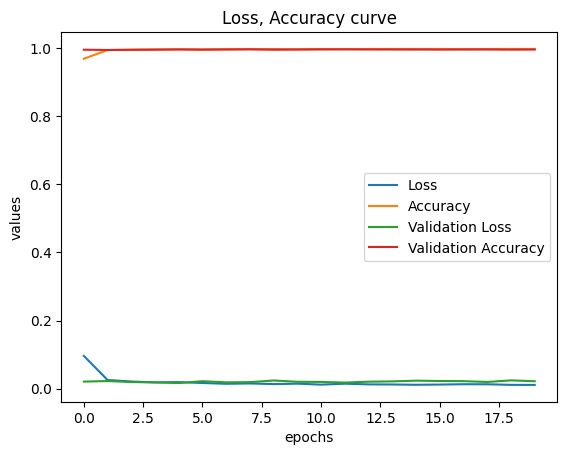

In [14]:
plt.title("Loss, Accuracy curve")
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('values')
plt.legend()
plt.show()

In [15]:
input_headline = 'Melissa Stark and Vickie Moran conducted a drill with RPG near East Andremouth around 13:30'
cleaned_input = clean_text(input_headline)
input_sequence = tokenizer.texts_to_sequences([cleaned_input])
input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post', truncating='post')
predicted_probabilities = model.predict(input_padded)
print(predicted_probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
[[9.7066337e-01 2.9300803e-02 3.5759753e-05]]


In [16]:
predicted_idx = np.argmax(predicted_probabilities, axis=1)
predicted_sentiment = label_Encoder.inverse_transform(predicted_idx)

print(f"Predicted sentiment for input '{input_headline}': {predicted_sentiment[0]}")

if predicted_sentiment[0] == 1:
    output = 'CRITICAL'
    colored_output = f'\033[91m{output}\033[0m'  # Red
elif predicted_sentiment[0] == 0:
    output = 'SUSPICIOUS'
    colored_output = output  # No color
elif predicted_sentiment[0] == -1:
    output = 'BENIGN'
    colored_output = f'\033[92m{output}\033[0m'  # Green
else:
    output = 'UNKNOWN 😕'
    colored_output = output

confidence = predicted_probabilities[0][predicted_idx[0]]

print(
    f"and the market sentiment is {colored_output} with confidence level {confidence:}"
)


Predicted sentiment for input 'Melissa Stark and Vickie Moran conducted a drill with RPG near East Andremouth around 13:30': -1
and the market sentiment is BENIGN with confidence level 0.9706633687019348


In [17]:
from keras.models import model_from_json
model_json = model.to_json()
with open("sentiment.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("sentiment.weights.h5")
model.save("sentiments.h5")
print("Model Saved")

Model Saved


In [282]:
import pickle
import numpy as np
import tensorflow as tf
from keras.models import load_model

# Paths (make sure names match your saved files)
MODEL_PATH = "sentiments.h5"
TOKENIZER_PATH = "tokenizer.pkl"

# Globals
model = None
tokenizer = None
MAX_SEQ_LEN = 18  # adjust based on training

def load_model_and_tokenizer():
    """Loads the model and tokenizer once"""
    global model, tokenizer
    
    if tokenizer is None:
        with open(TOKENIZER_PATH, "rb") as f:
            tokenizer = pickle.load(f)

    if model is None:
        model = tf.keras.models.load_model(MODEL_PATH)
        model.compile(optimizer="adam",
                      loss="categorical_crossentropy",
                      metrics=["accuracy"])
        print("✅ Model and tokenizer loaded successfully")

def classify_text(text: str):
    """Classifies input text into categories"""
    global model, tokenizer

    class_labels = ["benign", "suspicious", "critical"]
    # Ensure model is loaded
    if model is None or tokenizer is None:
        load_model_and_tokenizer()

    # Preprocess
    seq = tokenizer.texts_to_sequences([text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        seq, maxlen=MAX_SEQ_LEN, padding="post", truncating="post"
    )

    # Predict
    prediction = model.predict(padded)
    idx = int(np.argmax(prediction, axis=1)[0])
    confidence = float(np.max(prediction))

    return {
        "input_text": text,
        "predicted_class": class_labels[idx],
        "confidence": confidence
    }


# Example usage
if __name__ == "__main__":
    result = classify_text("two man spotted in a suspicious van")
    print(result)


✅ Model and tokenizer loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
{'input_text': 'two man spotted in a suspicious van', 'predicted_class': 'benign', 'confidence': 0.9989277720451355}
